#### Importing libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
import missingno as msno
import dateparser

from scipy import stats
from scipy.stats import norm, skew

#### Reading data

In [2]:
train = pd.read_csv("binaaz_train.csv")
test = pd.read_csv("binaaz_test.csv")
attractions = pd.read_excel('baku_coordinates.xlsx')
train.head()

,_id,title,price,price_currency,poster,poster_type,Ünvan,description,Yeniləndi,Mərtəbə,Sahə,Otaq sayı,Kupça,İpoteka,locations,latitude,longitude,seher
0,6,"Satılır 3 otaqlı yeni tikili 135 m², Gənclik m.",300000,AZN,Mubariz,vasitəçi (agent),"Bakı şəhəri, Bakıxanov küçəsi",Təcili Satılır...Qaz Kupça var..\nRoseville...,05 Fevral 2021,5 / 17,135 m²,3,var,yoxdur,\nGənclik m.\nRespublika stadionu \nNərimanov ...,40.400420,49.851554,baki
1,22,"Satılır 3 otaqlı yeni tikili 132.5 m², Nəriman...",153000,AZN,Самир Ахмедов,vasitəçi (agent),"Bakı şəhəri, ул.Табриза 21-23",Срочно.В Наримановском р-не недалеко от 162 шк...,05 Fevral 2021,10 / 16,132.5 m²,3,yoxdur,yoxdur,\nŞərq bazarı \nNərimanov r.\n\n,40.389663,49.853717,baki
2,72,"Satılır 2 otaqlı yeni tikili 115 m², Bayıl q.",171300,AZN,Fikrət,vasitəçi (agent),"Bakı şəhəri, Q.Abbasov küçəsi","Səbail rayonu ,Bayıl qəsəbəsi Q.Abbasov küçəsi...",05 Fevral 2021,7 / 14,115 m²,2,yoxdur,yoxdur,\nSəbail r.\nBayıl q.\n\n,40.347625,49.836685,baki
3,76,"Satılır 2 otaqlı yeni tikili 43 m², Masazır q.",44500,AZN,QASIM,vasitəçi (agent),"Bakı şəhəri, İstiqlaliyyət 14","Masazır qəsəbəsi, Yeni Bakı yaşayış kompleksi ...",05 Fevral 2021,4 / 8,43 m²,2,var,yoxdur,\nAbşeron r.\nMasazır q.\n\n,40.492294,49.747231,baki
4,86,"Satılır 2 otaqlı yeni tikili 65 m², Memar Əcəm...",89900,AZN,Heydər bəy,vasitəçi (agent),"Bakı şəhəri, Mir Cəlal küç.","Tecili satilir !!\n4 cu mikrorayonda, Elmed kl...",05 Fevral 2021,12 / 18,65 m²,2,var,yoxdur,\nMemar Əcəmi m.\nNəsimi r.\n4-cü mikrorayon q...,40.417271,49.810311,baki


In [3]:
print(train.shape)
print(test.shape)

(69315, 18)
(20000, 17)


In [4]:
train.columns

Index(['_id', 'title', 'price', 'price_currency', 'poster', 'poster_type',
       'Ünvan', 'description', 'Yeniləndi', 'Mərtəbə', 'Sahə', 'Otaq sayı',
       'Kupça', 'İpoteka', 'locations', 'latitude', 'longitude', 'seher'],
      dtype='object')

In [5]:
# popular =  list(zip(attractions.Latitude, attractions.Longitude))
# popular

In [6]:
# points = pd.DataFrame()
# points['points'] = list(zip(train.latitude, train.longitude))

In [7]:
# test_points = pd.DataFrame()
# test_points['points'] = list(zip(test.latitude, test.longitude))

In [8]:
# from geopy.distance import great_circle
# from tqdm import tqdm 

# for key,value in tqdm(zip(attractions['Title'],popular)):
#     train[key] = points['points'].apply(lambda x: great_circle(value, x).km)
    
# for key,value in tqdm(zip(attractions['Title'],popular)):
#     test[key] = test_points['points'].apply(lambda x: great_circle(value, x).km)    


In [9]:
test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
_id               20000 non-null int64
title             20000 non-null object
price_currency    20000 non-null object
poster            20000 non-null object
poster_type       20000 non-null object
Ünvan             20000 non-null object
description       19957 non-null object
Yeniləndi         20000 non-null object
Mərtəbə           20000 non-null object
Sahə              20000 non-null object
Otaq sayı         20000 non-null int64
Kupça             20000 non-null object
İpoteka           20000 non-null object
locations         20000 non-null object
latitude          20000 non-null float64
longitude         20000 non-null float64
seher             20000 non-null object
dtypes: float64(2), int64(2), object(13)
memory usage: 2.6+ MB


### Feature Extraction

In [10]:
def feature_extraction(df):   
    # null values
    df['Kupça'] = df['Kupça'].fillna(df['Kupça'].mode()[0], axis=0)
    df['description'] = df['description'].fillna(method='bfill', axis=0).fillna('empty description')


    df['kupca'] = pd.get_dummies(df['Kupça'], drop_first=True)
    df['mort'] = pd.get_dummies(df['İpoteka'], drop_first=True)
    df['poster_type'] = pd.get_dummies(df['poster_type'], drop_first=True)
    df['area'] = df['Sahə'].str.split().str[0].astype(float)
    df['rel_floor'] = df['Mərtəbə'].apply(lambda x: int(x.split('/')[0])/int(x.split('/')[1]))
    df['floor'] = df['Mərtəbə'].str.split('/').str[0].astype(float)
    df['AreaPerRooms'] = df['area']/df['Otaq sayı']
    
    df['kristalAbseron'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ["Kristal Abseron",'Kristal Abşeron',"Kistal Abşeron"]]))
    df['nearHospital'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['xestexana','klinika','klinka', 'xəstəxana', 'balnisiya', 'dogum evi', 'doğum evi']]))
    df['university'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['universitet','unverstit', 'unversitet']]))
    
    df['urg'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['tecili', 'təcili', 'tacili', 'tcili', 'təcılı','elimyandi', 'əlimyandı']]))
    df['nearHospital'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['xestexana','klinika','klinka', 'xəstəxana', 'balnisiya', 'dogum evi', 'doğum evi']]))
    df['urg'] = df['description'].apply(lambda x: any([w in str(x).lower() for w 
                                                   in ['tecili', 'təcili', 'tacili', 'tcili', 'təcılı','elimyandi', 'əlimyandı']]))
    df['deniz'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['deniz','dəniz']]))
    df['repaired'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['temirli','təmirli','temirri']]))
    df['unrepaired'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['temirsiz','təmirsiz','temırız']]))
    df['designed'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['dizayner','dizayn','dizayin','dızayın', 'dizayın']]))
    df['nearMetro'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['metro']]))
    df['nearGarden'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['bagca','baxça', 'bağça','baxca']]))
    df['podMayak'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['pod mayak', 'padmayak','podmoyak','padmoyak','podmayok','pad mayak','pad mayok']]))
    df['roomy'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['genis','geniş','qenis']]))
    df['perfect'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['ela','əla']]))
    df['communal'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['qaz','su','isig','isiq','işiq','işıq','işığ']]))
    df['notReady'] = df.description.map(lambda x:  any([w in str(x).lower() for w in ["tehvil verilecek", "təhvil veriləcək", "təhfil veriləcək", "təhvil veriləcəy", "hazır deyil", "hazır olacaq", "hazir olacaq"]]))
    df['nearSchool'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['mekteb','məktəb','məktəp','lisey', 'litsey', 'liçsey']]))
    df['nearShopping'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['market','magaza','mağaza','dukan','dükan']]))
    df['kristalAbseron'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ["Kristal Abseron",'Kristal Abşeron',"Kistal Abşeron"]]))
    df['hasContact'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['elaqe','əlaqə','elaqə','nörmə','nomre','nömre']]))
    df['nearHospital'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['xestexana','klinika','klinka', 'xəstəxana', 'balnisiya', 'dogum evi', 'doğum evi']]))
    df['university'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['universitet','unverstit', 'unversitet']]))
    df['funcenter'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['eylence','əyləncə']]))
    df['liveable'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['yaşayış', 'yasayis', 'yaşayiş']]))
    df['lift'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['lift','lifd']]))
    df['fastLift'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['suretli lift',' suretli lifd','sürətli lift']]))
    df['garage'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['qaraj','garaj']]))
    df['supermarket'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['araz','spar','bravo','bazarstore', 'bazar stor']]))
    df['furniture'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['mebel', 'əşya', 'esya','avadanlig','avadanliq','avadanlıq', 'avadanlığ']]))
    df['jacuzzi'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['jakuzzi','jacuzzi','modern hamam','super hamam']]))
    df['tax'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['1%']]))
    df['floor'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['parket', 'isti döşəmə']]))
    df['heatSystem'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['kombi','istiliy sistem','istilik sistem']]))
    df['security'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['tehlukesiz','təhlükəsiz', 'təhlükesiz']]))
    df['newlyBuilt'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['yeni tikili', 'teze tikili']]))
    df['newlyReaired'] = df['description'].apply(lambda x: any([w in str(x).lower() for w in ['yeni temir', 'yeni təmir', 'təzə temir', 'teze temir', 'yenicə təmir', 'yenice temir']]))
    
    
    return df

In [11]:
train['floor'] = train['Mərtəbə'].str.split('/').str[0].astype(float)
test['floor'] = test['Mərtəbə'].str.split('/').str[0].astype(float)

In [12]:
train = feature_extraction(train)
test = feature_extraction(test)

### Outliers

In [13]:
train.describe()

,_id,price,poster_type,Otaq sayı,latitude,longitude,kupca,mort,area,rel_floor,AreaPerRooms
count,69315.000000,6.931500e+04,69315.000000,69315.000000,69315.000000,69315.000000,69315.000000,69315.000000,69315.000000,69315.000000,69315.000000
mean,69354.073462,1.928901e+05,0.884628,2.779124,40.398972,49.842873,0.274024,0.864358,189.700990,0.574914,65.657792
std,46130.321678,1.880708e+05,0.319472,0.966102,0.190983,0.743952,0.446025,0.342410,4720.976214,0.260435,1377.288915
min,1.000000,1.000000e+01,0.000000,1.000000,39.247907,-144.714092,0.000000,0.000000,0.100000,0.000008,0.050000
25%,29066.500000,1.050000e+05,1.000000,2.000000,40.382464,49.808933,0.000000,1.000000,75.000000,0.352941,33.000000
50%,61309.000000,1.500000e+05,1.000000,3.000000,40.393477,49.837887,0.000000,1.000000,105.000000,0.583333,40.000000
75%,118875.500000,2.290000e+05,1.000000,3.000000,40.405799,49.871810,1.000000,1.000000,139.000000,0.800000,47.000000
max,147190.000000,1.275000e+07,1.000000,20.000000,89.464469,50.331135,1.000000,1.000000,850000.000000,1.000000,212500.000000


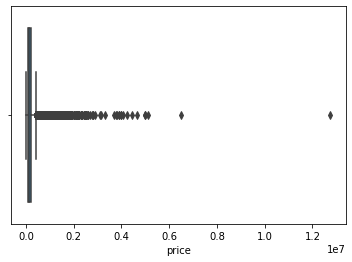

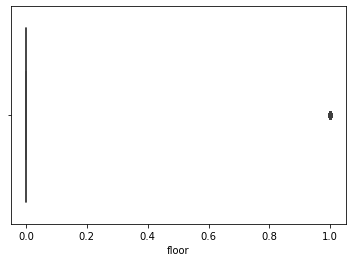

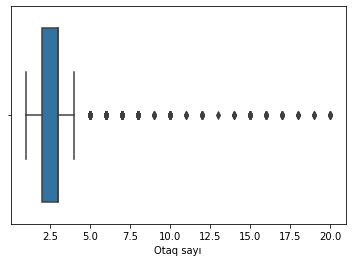

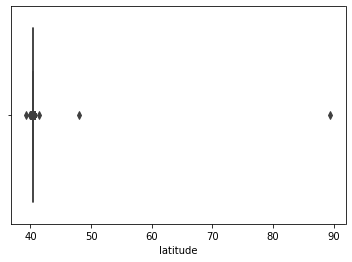

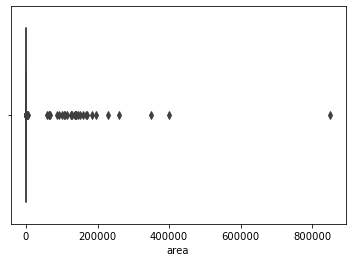

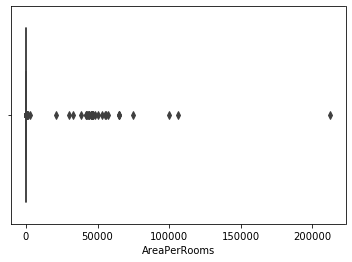

In [14]:
outlier = ['price','floor','Otaq sayı','latitude','area','AreaPerRooms']

for i in outlier:
    sns.boxplot(train[i])
    plt.show()

In [15]:
def remove_outliers(df):
    df = df[(df['area']>10)&(df['area']<1000)]
    df = df[df['Otaq sayı']<18]
    df = df[df['floor']<26]
    df = df[(df['price']>15000)&(df['price']<1000000)]
    df = df[(df['price']/df['area']>200)&(df['price']/df['area']<4000)]
    df = df[(df['AreaPerRooms']>12)&(df['AreaPerRooms']<95)]
    df = df[df['latitude']<43.5]
    
    return df

In [16]:
train = remove_outliers(train)

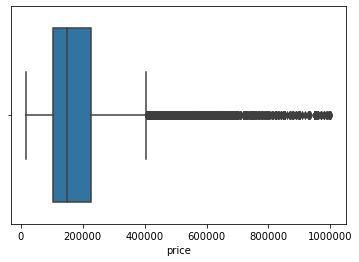

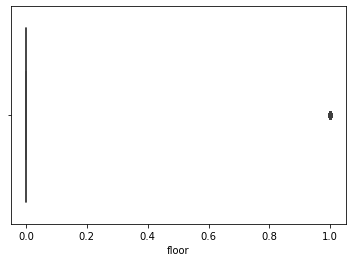

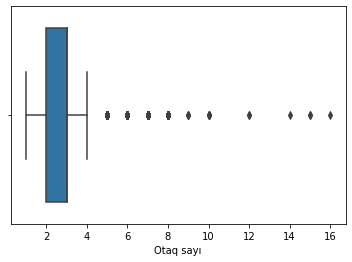

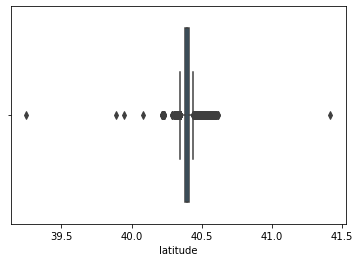

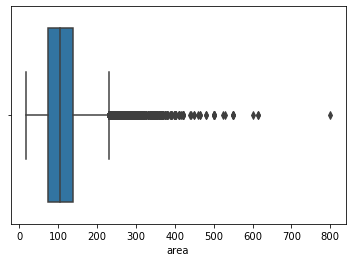

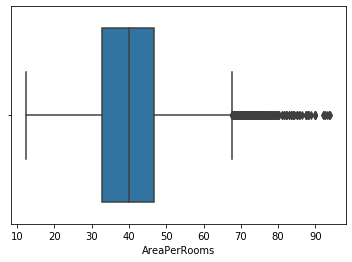

In [17]:
for i in outlier:
    sns.boxplot(train[i])
    plt.show()

In [18]:
train.describe()

,_id,price,poster_type,Otaq sayı,latitude,longitude,kupca,mort,area,rel_floor,AreaPerRooms
count,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000
mean,69364.471553,180014.385816,0.885699,2.749706,40.398298,49.845823,0.276229,0.863361,111.937537,0.575245,40.493624
std,46143.405398,116015.648430,0.318179,0.857513,0.029756,0.059178,0.447135,0.343468,49.111355,0.260300,10.218196
min,1.000000,16000.000000,0.000000,1.000000,39.247907,48.427218,0.000000,0.000000,17.000000,0.000008,12.333333
25%,29061.750000,105000.000000,1.000000,2.000000,40.382697,49.808791,0.000000,1.000000,75.000000,0.352941,32.766667
50%,61295.000000,149000.000000,1.000000,3.000000,40.393575,49.837632,0.000000,1.000000,104.000000,0.588235,40.000000
75%,118896.000000,225000.000000,1.000000,3.000000,40.406123,49.871837,1.000000,1.000000,137.000000,0.800000,46.666667
max,147190.000000,999999.000000,1.000000,16.000000,41.415550,50.331135,1.000000,1.000000,800.000000,1.000000,94.000000


### Visualization

In [19]:
df = train

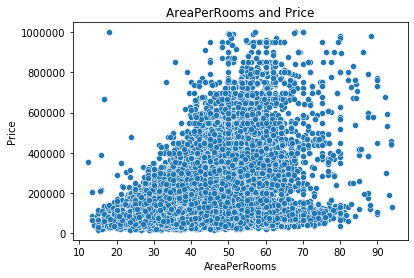

In [20]:
ax = sns.scatterplot(x="AreaPerRooms", y="price", data=df);
ax.set_title("AreaPerRooms and Price")
ax.set_xlabel("AreaPerRooms");
ax.set_ylabel("Price");

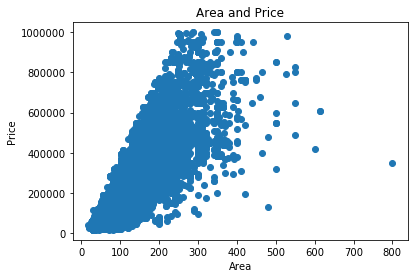

In [21]:
plt.scatter(train['area'], df['price']) 

plt.title("Area and Price")
plt.xlabel('Area')
plt.ylabel('Price')
  
plt.show()

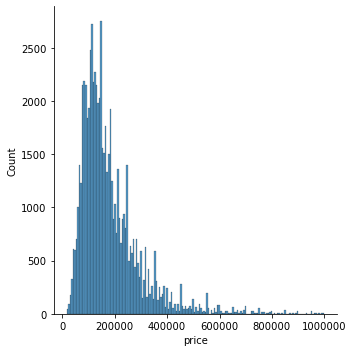

In [22]:
sns.displot(df['price'])

In [23]:
print(df['price'].skew())
print(df['price'].kurt())

2.1842977241549626
7.254766576933064



 mu = 180014.39 and sigma = 116014.80



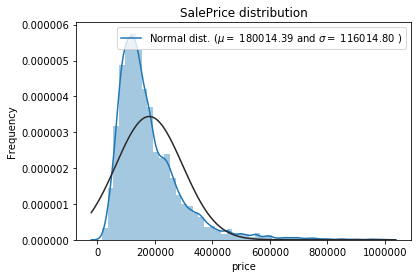

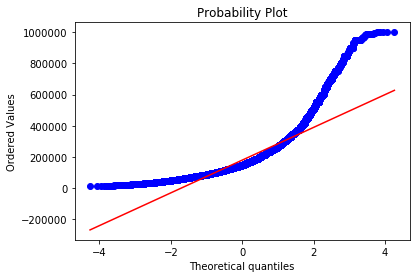

In [24]:
sns.distplot(df['price'] , fit=norm);

(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show()

### Correlation

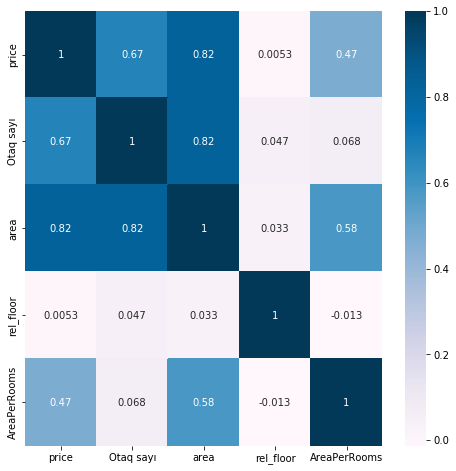

In [25]:
plt.figure(figsize=(8,8))
cor = df[['price', 'Otaq sayı', 'area', 'rel_floor', 'AreaPerRooms']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [26]:
cor_target = abs(cor["price"]) # absolute value of the correlation 

relevant_features = cor_target[cor_target>0.2] # highly correlated features 

names = [index for index, value in relevant_features.iteritems()] # getting the names of the features 

names.remove('price') # removing target feature 

print(names) # printing the features 
print(len(names))

['Otaq sayı', 'area', 'AreaPerRooms']
3


#### Building Model

In [27]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [28]:
print(train.shape, test.shape)

(68092, 55) (20000, 54)


In [29]:
drop_list=['title', 'price_currency', 'poster', 'Ünvan', 'description', 'Yeniləndi', 'Mərtəbə', 'Sahə', 'Kupça', 'İpoteka', 'locations', 'seher']
train.drop(drop_list,axis=1,inplace=True)
test.drop(drop_list,axis=1,inplace=True)

In [30]:
x=train.copy()
x.drop('price',axis=1,inplace=True)
y=train['price']
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=20000,random_state=171)
model = XGBRegressor()
paramater = { }
clf = GridSearchCV(model, paramater, cv=5)

clf.fit(X_train,Y_train)
Y_train_pred=clf.predict(X_train)
Y_test_pred=clf.predict(X_test)

In [31]:
test_score=clf.score(X_test, Y_test)
test_score

0.897461122023376

#### Hyperparameter Tuning

In [32]:
def results(Y_train, Y_train_pred, Y_test, Y_test_pred, model, score, X_train, X_test):
    print(type(model).__name__)
    print('Train Mse: {}'.format(mean_squared_error(Y_train, Y_train_pred)))
    print('Train Score: {}'.format(model.score(X_train, Y_train)))
    print('Test Mse: {}'.format(mean_squared_error(Y_test, Y_test_pred)))
    print('Test Score: {}'.format(model.score(X_test, Y_test)))
    print('Mean of Cross Validation Score: {}'.format(np.round(score.mean(),4)))
    print('------------------------------------------------------')

In [33]:
def model_tunings(x,y, model_params):
    results=[]
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=20000, random_state=171)  
    for model_name, mp in model_params.items():
        clf=GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=True)
        clf.fit(X_train, Y_train)
        Y_train_pred=clf.predict(X_train)
        Y_test_pred=clf.predict(X_test)
        train_error=mean_squared_error(Y_train, Y_train_pred)
        train_score=clf.score(X_train, Y_train)
        test_error=mean_squared_error(Y_test, Y_test_pred)
        test_score=clf.score(X_test, Y_test)
        print(model_name)
        print('Train Mse: {}'.format(train_error))
        print('Train Score: {}'.format(train_score))
        print('Test Mse: {}'.format(test_error))
        print('Test Score: {}'.format(test_score))
        print('------------------------------------------------------')
        results.append({'model': model_name, 
                        'Train Error': train_error,
                        'Train Score': train_score,
                        'Test Error': test_error,
                        'Test Score': test_score,
                        'best_score': clf.best_score_,
                        'best_params': clf.best_params_})
    return results

In [34]:
model_parameters={
    'LGBMRegressor': {
        'model': LGBMRegressor(),
        'params': {'learning_rate ': [0.001, 0.0005, 0.01], 'max_depth': [7,10,13,16], 
                   'n_estimators': list(range(200,1100,100))}},
    'XGBRegressor': {
        'model' : XGBRegressor(),
        'params' : {'reg_alpha': [0.55, .6, 0.51],
                    'reg_lambda': [0.5, 0.4, 0.55],
                    'max_depth': list(range(7, 20, 2))}
    }
}

In [35]:
X = train.drop('price', axis=1)
Y = train[['price']]

In [36]:
scores = model_tunings(X, Y, model_parameters)

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learn

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learn

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learn

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learn

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1,

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1,

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.0005
[LightGBM] [Warning] learning_rate is set=0.1,

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_ra

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_ra

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_ra

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_ra

In [37]:
res = pd.DataFrame(scores, columns=['model', 'Train Error', 'Train Score', 'Test Error', 'Test Score',
       'best_score', 'best_params'])

In [38]:
res_sorted=res.sort_values('Test Error', ascending = True)
res_sorted

,model,Train Error,Train Score,Test Error,Test Score,best_score,best_params
0,LGBMRegressor,4.244121e+08,0.968793,1.161575e+09,0.911476,0.907852,"{'learning_rate ': 0.001, 'max_depth': 13, 'n_..."
1,XGBRegressor,2.126314e+08,0.984365,1.247557e+09,0.904923,0.898084,"{'max_depth': 9, 'reg_alpha': 0.51, 'reg_lambd..."


In [39]:
res_sorted.best_params[1]

{'max_depth': 9, 'reg_alpha': 0.51, 'reg_lambda': 0.5}

#### Kaggle Part

In [40]:
X = train.drop('price', axis=1)
Y = train[['price']]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=20000,random_state=42)
print(X.shape, Y.shape)

(68092, 42) (68092, 1)


In [41]:
test.shape

(20000, 42)

In [42]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(48092, 42) (48092, 1)
(20000, 42) (20000, 1)


In [43]:
model = XGBRegressor(max_depth=11, reg_alpha=0.51, reg_lambda=0.55)
# model = LGBMRegressor(learning_rate=0.001, max_depth= 10, n_estimators=1000)
model.fit(X,Y)
tuned_pr=model.predict(test)

In [44]:
test_score= model.score(X_test, Y_test)
test_score

0.9924563020652157

In [45]:
tuned_res=[i for i in tuned_pr]

In [46]:
submission=pd.DataFrame()
submission['_id']=test['_id']
submission['price']=tuned_res

In [47]:
submission.to_csv('least.csv',index=False)